# Recurrent Neural Network Stock Prediction

In this notebook, I look at making stock predictions using a recurrent neural network, specifically a gated recurrent unit. In this project, I predict `Tesla` closing prices from [Alpha Vantage](https://www.alphavantage.co)

## Loading the Data

First, we'll import our needed libraries:
- `torch`: For training our model
- `torch.nn`: Shortcut for neural network model
- `requests`: API GET HTTP request for stock data
- `pandas`: Organization of our data
- `matplotlib`: Data visualization
- `numpy`: Vectorized operations
- `time`: Measures system performance

In [1]:
import torch
import torch.nn as nn
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

We'll also declare the ticker symbol of the stock we'll be using in the variable `stock`. In this case, we'll be using `TSLA` for Tesla

If you are running this notebook on your own, feel free to change it!

In [2]:
stock = "TSLA"

Next, we'll call our API from [Alpha Vantage](https://www.alphavantage.co) with the appropriate parameters:
- `function = TIME_SERIES_INTRADAY_EXTENDED`: Using data within a day
- `symbol = TSLA`: The stock ticker for analysis
- `interval = '15min'`: Time interval within the day
- `slice = 'year1month1'`: Data over an entire year
- `adjusted = true`: Adjusted stock data
- `apikey`: My personal API key (hidden)

In [3]:
response = requests.get(f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol={stock}&interval=15min&slice=year1month1&adjusted=true&apikey={api_key}")

After our API request, we'll parse our data and organize the numerical values into a dataframe called `df_data`

In [4]:
# parse the text
txt = response.text.split("\r\n")
data = [t.split(",") for t in txt]
data.reverse()

# convert list of lists into pandas dataframe
df = pd.DataFrame(data[1:-1])
df.columns = data[-1]
df_data = df[["open", "high", "low", "close", "volume"]].astype(float)

# give a summary of the data
df_data.head()

,open,high,low,close,volume
0,585.00,589.70,584.79,587.64,36726.0
1,586.50,588.00,586.07,586.72,11048.0
2,587.33,588.00,584.24,584.90,10448.0
3,584.57,586.50,583.30,586.50,13796.0
4,586.00,586.58,585.01,586.50,5282.0


We're dealing with a lot of large numbers, so we'll have to normalize the data with `min-max` normalization, which uses the following formula:

\begin{equation}
x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}
\end{equation}

*Note: this normalization does cause some bias, because the data technically shouldn't be able to look too far into the future. However, we'll assume this difference to be negligible*

In [5]:
norm_df = (df_data - df_data.min()) / (df_data.max() - df_data.min())

To get a baseline of our data, we'll plot the closing price of our `Tesla` stock

Text(0, 0.5, 'Standardized Closing Price')

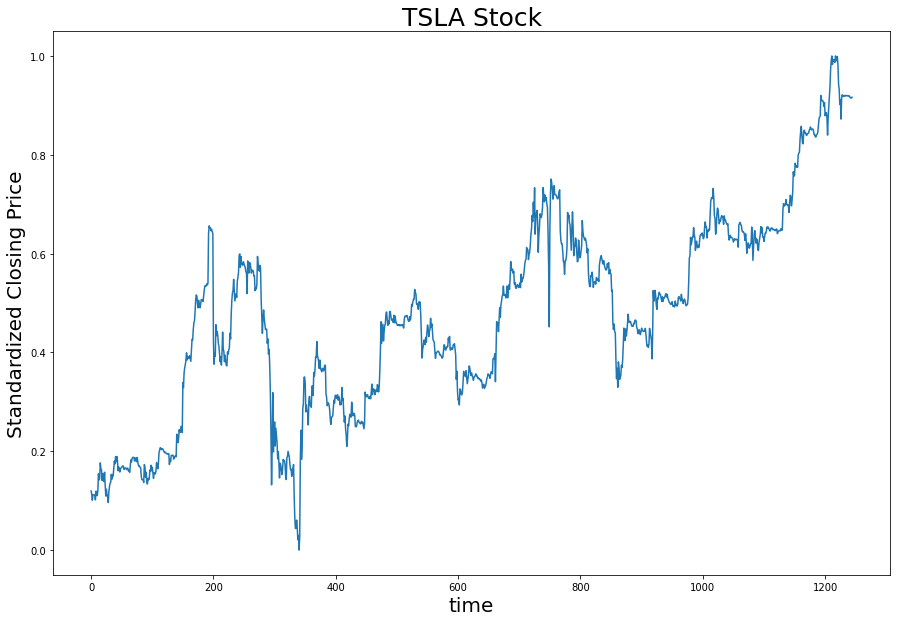

In [6]:
# set the plot size
fig = plt.gcf()
fig.set_size_inches(15, 10)

# plot the data
plt.plot(norm_df["close"])

# adjust labels
plt.title(f"{stock} Stock", size = 25)
plt.xlabel("time", size = 20)
plt.ylabel("Standardized Closing Price", size = 20)

For our recurrent neural network, we'll attempt to predict the `Closing Price` data with a time-series model

Hence, our first step is to define a `lookback` value, to determine how many past data points the model will use the make predictions

In [7]:
lookback = 20

Next, we'll create our `x` and `y` datasets using the `lookback` value

In [8]:
# get the raw data and declare our input data
close_data_raw = norm_df[["close"]].to_numpy()
close_data = []

# iterate through and add the appropriate points
for index in range(len(close_data_raw) - lookback): 
    close_data.append(close_data_raw[index: index + lookback])

# convert to a numpy array
close_data = np.array(close_data)

Now we'll declare our training and testing sizes. For this project, we'll use an `80-20` split

In [9]:
# calculate appropriate sizes
test_size = int(np.round(0.2 * close_data.shape[0]))
train_size = close_data.shape[0] - (test_size)

print(train_size, test_size)

980 245


Great! We now have a training size of `980` and a testing size of `245`

Now we can use array indexing with our `x` and `y` data to split up our datasets

In [10]:
# x value arrays
x_train_arr = close_data[:train_size,:-1,:]
x_test_arr = close_data[train_size:,:-1]

# y value arrays
y_test_arr = close_data[train_size:,-1,:]
y_train_arr = close_data[:train_size,-1,:]

`Pytorch` uses a specific data structure, a `torch` to perform its calculations. Thus, we'll need to convert these `numpy` arrays into `torches`

In [11]:
# convert x values into torches
x_train = torch.from_numpy(x_train_arr).type(torch.Tensor)
x_test = torch.from_numpy(x_test_arr).type(torch.Tensor)

# convert y values into torches
y_train = torch.from_numpy(y_train_arr).type(torch.Tensor)
y_test = torch.from_numpy(y_test_arr).type(torch.Tensor)

## Training the Model

First, we will declare the following needed values for our recurrent neural network:
- `input_dim`: The dimension of the input layer
- `hidden_dim`: The dimension of the hidden layer
- `num_layers`: The total number of layers in the model
- `output_dim`: The output dimension
- `num_epochs`: The number of epochs to train
- `sample_size`: The number of data entires

In [12]:
# declare needed variables
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100
sample_size = train_size + test_size

Now we need to create our model

There were a few recurrent neural network models I was considering trying, mainly `LSTM` and `GRU` networks, but I decided on the `GRU` neural network. The reason for this was because this model will end up being deployed on a `Flask` application, so I wanted its computation to be relatively inexpensive

A visual representation of the `GRU` model can be found below:

<img src="./images/GRU.png"></img>

To follow the [Pytorch Documentation](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module), we'll create a `GRU` module with two methods: `__init__()` and `forward()`

#### `__init__(self, input_dim, hidden_dim, num_layers, output_dim)`

This method initialize the `GRU` for our model

It starts by calling the super class for the model and defines the hidden layer dimensions and number of layers in the network

Afterwards, it creates `GRU` and `Linear` networks using the parameters above

#### `forward(self, x)`

This method forward propogates, allowing us to make predictions with our model

First we create a `hidden_layer` of zeros and of the appropriate size. We also make sure this layer requires a gradient so that it can be backpropogated

Afterwards, we use the initialized `GRU` network above to make a prediction using `x`, our input, and the `hidden_layer`

Finally, we use the `Linear` network to make our final predictions, and return its output

In [13]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        # call parent constructor
        super(GRU, self).__init__()
        
        # intialize variables
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # initialize neural network layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first = True)
        self.lin = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # calculate the hidden layer
        hidden_layer = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        # use the GRU network
        out, (hn) = self.gru(x, (hidden_layer.detach()))
        
        # predict with the Linear network
        return self.lin(out[:, -1, :]) 

Now that the class has been created, we can create the model appropriately

First we'll use the `GRU` constructor we defined above to initialize the neural network

Next, we'll create a `Loss Function` to measure the cost of our model. We'll be using [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error), which has the following formula:

\begin{equation}
MSE = \frac{1}{n}\sum_{i = 1}^{n} (x_i - \hat{x}_i)^2
\end{equation}

Finally, we choose our optimizer for backpropogation, which is the [Adam algorithm](https://arxiv.org/abs/1412.6980). We set the loss ratio of this optimizer as `0.01`

In [14]:
# create the model
model = GRU(input_dim, hidden_dim, num_layers, output_dim)

# choose the loss function
loss_func = torch.nn.MSELoss(reduction = 'mean')

# select an optimizer algorithm
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

Now that the model is set up, we can train our model

We will iterate through each epoch and in each iteration:
1. Predict with our model
2. Evaluate the loss for the model
3. Back propogate accordingly

Additionally, we'll store the loss at each epoch, as well as record the starting and ending times to see the speed of the algorithm

In [15]:
# declare needed variables
loss_vals = np.zeros(num_epochs)
start_time = time.time()

for epoch in range(num_epochs):
    # predict with the model
    y_train_pred = model(x_train)
    
    # calculate the losd values
    loss = loss_func(y_train_pred, y_train)
    loss_vals[epoch] = loss.item()
    
    # adjust the model accordingly
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# print the training time
print(f"Training time: {time.time() - start_time}")

Training time: 11.22115159034729


## Model Evaluation

Now that the model has been fully trained, we need to validate it

First, we'l create a plot of our loss values over time, just to make sure it decreased as expected

Text(50, 0.01, 'Final Loss: 0.000608')

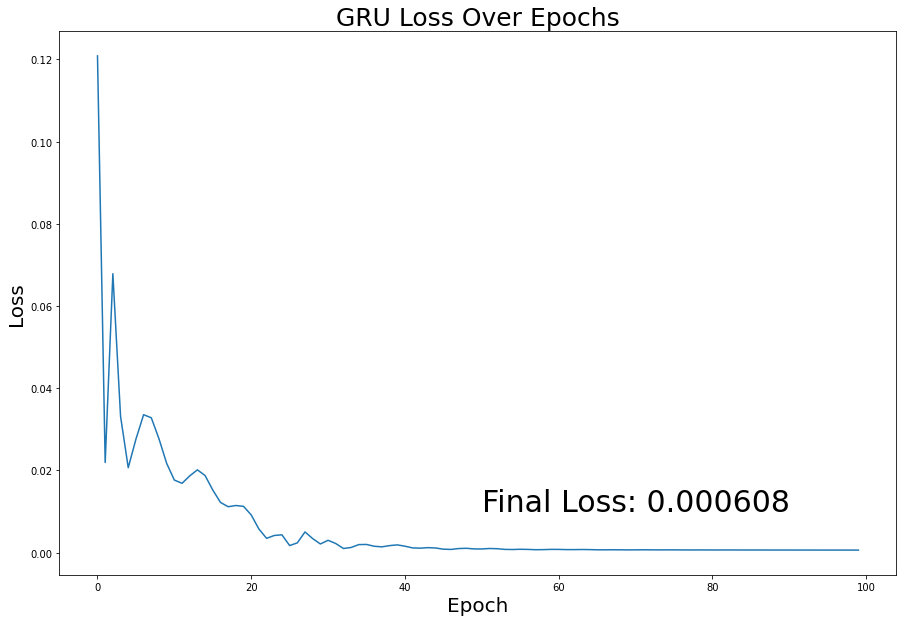

In [16]:
# set the plot size
fig = plt.gcf()
fig.set_size_inches(15, 10)

# plot the loss data
plt.plot(loss_vals)

# adjust labels
plt.title("GRU Loss Over Epochs", size = 25)
plt.xlabel("Epoch", size = 20)
plt.ylabel("Loss", size = 20)

# add loss text
plt.text(50, 0.01, f"Final Loss: {round(loss_vals[-1], 6)}", size = 30)

Our loss is low and we used just about the correct number of epochs, so now we can visually compare our results

We'll create the method `plot_data()` to help us do this repeatedly

In [17]:
def plot_data(pred, act, title, col1, col2):
    # create the plot
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 10)

    # plot the training data
    ax.plot(pred, col1, label = "Predicted")
    ax.plot(act, col2, label = "Actual")

    # adjust labels
    plt.title(title, size = 25)
    plt.xlabel("time", size = 20)
    plt.ylabel("Standardized Closing Price", size = 20)

    # plot the legend
    plt.legend(loc = "lower right", fontsize = "xx-large")

First, we'll plot the `training` set

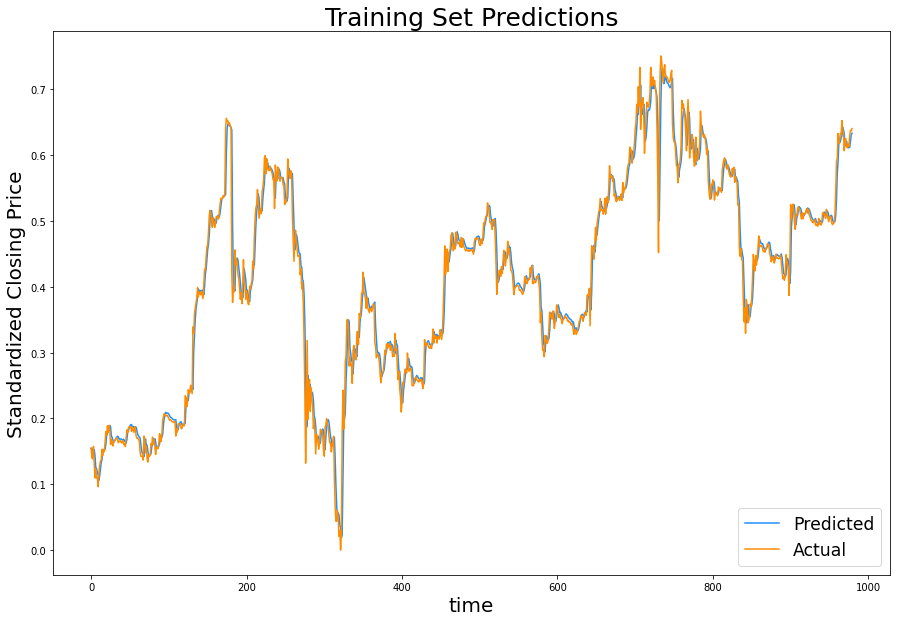

In [18]:
# obtain the training data
pred_train = model(x_train).detach().numpy()
act_train = y_train
title = "Training Set Predictions"

# plot the results
plot_data(pred_train, act_train, title, "dodgerblue", "darkorange")

We notice that our training data is spot on! This is to be expected since the value for `loss` was so low

Now we'll plot the `testing set`

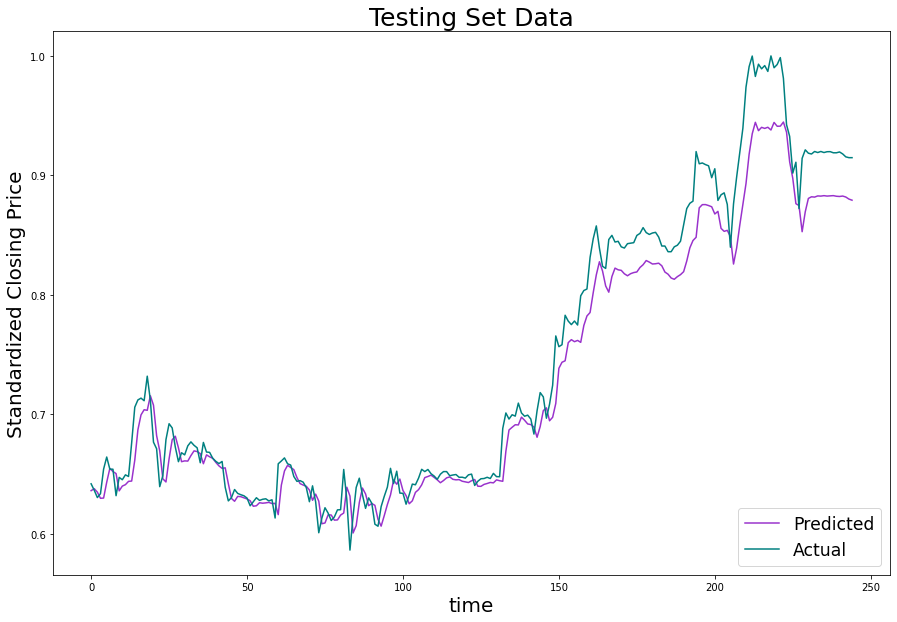

In [19]:
# obtain the testing data
pred_test = model(x_test).detach().numpy()
act_test = y_test
title = "Testing Set Data"

# plot the results
plot_data(pred_test, act_test, title, "darkorchid", "teal")

In the testing set, our model seems to underestimate or overestimate the data sometimes, but overall, it's fairly consistent!

We'll now combine every predicted and actual value to visually see all of the predictions

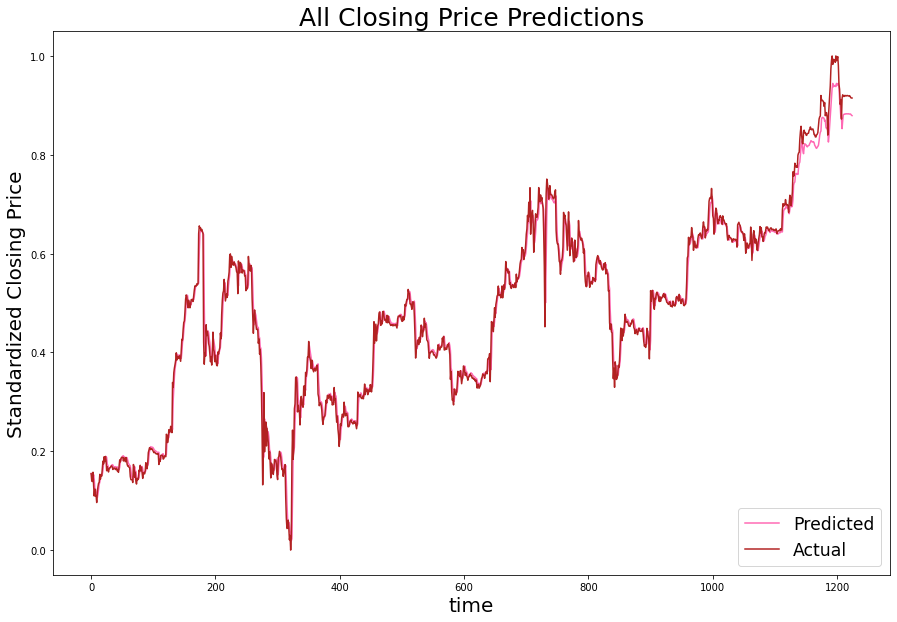

In [20]:
all_pred_vals = np.concatenate((pred_train, pred_test), 0)
all_act_vals = np.concatenate((y_train, y_test), 0)
title = "All Closing Price Predictions"

plot_data(all_pred_vals, all_act_vals, title, "hotpink", "firebrick")

Overall, we can see that the `GRU` does a pretty good job of predicting these stock prices!

## Making Future Predictions

Since our model has been finely-tuned to the best of our ability, we can use it to make future predictions!

We can do this by using a sliding window technique using the following steps:
1. Temporarily create a `torch` window, `temp_window`
2. Obtain our prediction, `pred` from `temp_window`
3. Pop the oldest value from `window`, and append `pred` to `window`
4. Repeat steps 1-3 

In [21]:
# intialize variables
future_preds = [close_data_raw[-1][0]]
window = x_test[-1,:,:]
num_intervals = 48

for i in range(num_intervals):
    # create a temporary window
    temp_window = torch.reshape(window, (1, 19, 1))
    
    # obtain our current prediction and append it to the list
    curr_pred_torch = model(temp_window)
    curr_pred = curr_pred_torch.detach().numpy().flatten()[0]
    future_preds.append(curr_pred)
    
    # push and pop from the window accordingly
    window = window[1:]
    window = torch.cat((window, torch.from_numpy(np.array([[curr_pred]]))))

Finally, we'll plot these predictions

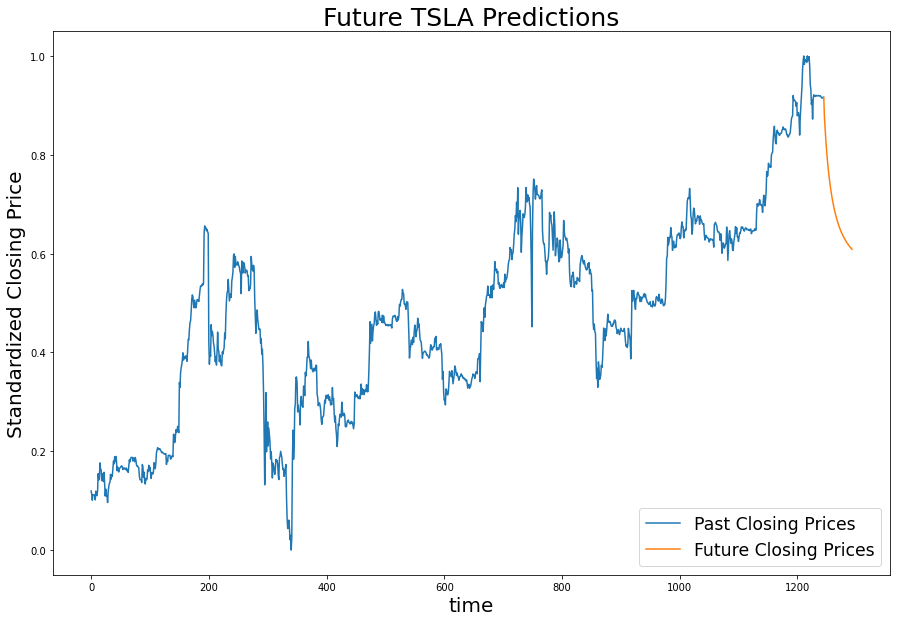

In [22]:
# create the plot
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

# plot the future prediction data
ax.plot(close_data_raw, label = "Past Closing Prices")
ax.plot(np.arange(num_intervals + 1) + close_data_raw.size, future_preds, label = "Future Closing Prices")

# adjust the labels
plt.title(f"Future {stock} Predictions", size = 25)
plt.xlabel("time", size = 20)
plt.ylabel("Standardized Closing Price", size = 20)

# plot the legend
plt.legend(loc = "lower right", fontsize = "xx-large")

According to our model, the `TSLA` prices are expected to go down. Hopefully you don't have any `TSLA` stocks!

## Conclusion and Future Work

In conclusion, I learned a lot from this project! This was my first real experience with `Pytorch`, and I was extremely happy with its ease of transition from `numpy`. I obtained more hands-on experience with Neural Networks and Machine Learning, and this was my first time ever working with a Recurrent Neural Network. I learned that the `LTSM` and `GRU` networks each have their own advantanges and disadvantages, and it was interesting to see the tradeoffs between the models

In the future, I hope I will be able to further expand upon this project to make the future predictions more accurate and robust. Right now, the `GRU` model predicts future stocks exponentially, and I want to do more research into the math behind the algorithm to see why that is. I believe that there are more complex variables I could add to this model, such as news sentiment or the state of the world's economy, that would help boost the predictions of this model. I want to eventually deploy this notebook into a `Flask` application, which fortunately seems extremely doable!

## Sources

This project relied heavily on [this paper](https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632) by Rodolfo Saldanha, so thank you for putting out this information and making it accessible for beginners!